In [21]:
import gymnasium as gym
import json
import pathlib
import numpy as np
from PIL import Image
from IPython.display import display
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
from gymnasium import Wrapper
from gymnasium.wrappers import RecordVideo
from gymnasium.spaces import Box, Discrete

In [22]:
def char_to_description(char):
    if char == b'F':
        return 'normal ground'
    elif char == b'H':
        return 'a deadly trap'
    elif char == b'S':
        return 'the starting position'
    elif char == b'G':
        return 'the final goal'
    else:
        return 'a wall'

def get_goal_direction(agent_position, goal_position):
    agent_row, agent_col = agent_position
    goal_row, goal_col = goal_position

    # Calculate the row and column differences
    row_diff = goal_row - agent_row
    col_diff = goal_col - agent_col

    # Define cardinal directions
    cardinal_directions = {
        (0, 1): 'east',
        (1, 0): 'south',
        (0, -1): 'west',
        (-1, 0): 'north'
    }

    # Check if the goal is directly reachable from the agent's position
    for direction, cardinal in cardinal_directions.items():
        if (row_diff, col_diff) == direction:
            return cardinal

    # If the goal is not directly reachable, determine the relative direction
    if row_diff > 0:
        row_dir = 'south'
    elif row_diff < 0:
        row_dir = 'north'
    else:
        row_dir = ''

    if col_diff > 0:
        col_dir = 'east'
    elif col_diff < 0:
        col_dir = 'west'
    else:
        col_dir = ''

    return row_dir + '-' + col_dir

def get_agent_position(grid_world, number):
    row = number // len(grid_world[0])
    col = number % len(grid_world[0])
    return row, col

def get_goal_position(grid_world):
    goal_position = (len(grid_world)-1, len(grid_world[0])-1) #row, column
    assert grid_world[goal_position] == b'G'
    return goal_position

def get_neighbors(grid_world, position):
    row, col = position
    neighbors = {}

    # UP
    if row > 0:
        neighbors['UP'] = char_to_description(grid_world[row - 1][col])
    else:
        neighbors['UP'] = char_to_description(None)

    # DOWN
    if row < len(grid_world) - 1:
        neighbors['DOWN'] = char_to_description(grid_world[row + 1][col])
    else:
        neighbors['DOWN'] = char_to_description(None)

    # LEFT
    if col > 0:
        neighbors['LEFT'] = char_to_description(grid_world[row][col - 1])
    else:
        neighbors['LEFT'] = char_to_description(None)

    # RIGHT
    if col < len(grid_world[0]) - 1:
        neighbors['RIGHT'] = char_to_description(grid_world[row][col + 1])
    else:
        neighbors['RIGHT'] = char_to_description(None)

    return neighbors

def describe_position(grid_world, agent_position_by_number=0):

    # Get the position of the agent
    agent_position = get_agent_position(grid_world, agent_position_by_number)

    # Get what the agent sees in each direction
    neighbors = get_neighbors(grid_world, agent_position)

    # get goal position
    goal_direction = get_goal_direction(agent_position, get_goal_position(grid_world))

    description = f"the agent sees:\n {neighbors['UP']} north of him, {neighbors['DOWN']} south of him, {neighbors['LEFT']} west of him, {neighbors['RIGHT']} east of him. The goal is {goal_direction} of him."
    return description

In [23]:

class PositionToImageAndDescription(Wrapper):
  def __init__(self, env, obs_shape):
      super().__init__(env)
      self.observation_space = Box(shape=obs_shape, low=0, high=255)

  def step(self, action):
      obs, reward, terminated, truncated, info = self.env.step(action)
      info['obs'] = describe_position(self.desc, agent_position_by_number=obs)
      obs = self.env.render()
      return obs, reward, terminated, truncated, info
  
  def reset(self, **kwargs):
      obs, info = self.env.reset(**kwargs)
      info['obs'] = describe_position(self.desc, agent_position_by_number=obs)
      obs = self.env.render()
      return obs, info

class StatsRecorder(Wrapper):
  def __init__(self, env, stat_folder):
    super().__init__(env)
    self._directory = pathlib.Path(stat_folder).expanduser()
    self._directory.mkdir(exist_ok=True, parents=True)
    self._file = (self._directory / 'stats.jsonl').open('a')
    self._length = None
    self._reward = None
    self._stats = None

  def reset(self, **kwargs):
    obs, info = self.env.reset(**kwargs)
    self._length = 0
    self._reward = 0
    self._stats = None
    return obs, info

  def step(self, action):
    obs, reward, terminated, truncated, info = self.env.step(action)
    self._length += 1
    self._reward += reward
    done = terminated or terminated
    if done:
      self._stats = {'length': self._length, 'reward': round(self._reward, 1)}
      self._save()
    return obs, reward, terminated, truncated, info

  def _save(self):
    self._file.write(json.dumps(self._stats) + '\n')
    self._file.flush()
 

In [24]:
gym.__version__

'0.29.1'

In [25]:
def make_frozen_env(
    outdir,
    map_size=8, # 8x8
    is_slippery=True,
    save_video=False,
    save_video_every=100
):
    def frozen_thunk():
        dummy_env_to_get_observation_dim = gym.make("FrozenLake-v1", render_mode="rgb_array", map_name=None, desc=generate_random_map(size=map_size), is_slippery=is_slippery)
        _, _ = dummy_env_to_get_observation_dim.reset(seed=1234)
        img = dummy_env_to_get_observation_dim.render()
        obs_shape = np.array(img).shape
        del dummy_env_to_get_observation_dim

        frozen_env = gym.make("FrozenLake-v1", render_mode="rgb_array", map_name=None, desc=generate_random_map(size=map_size), is_slippery=is_slippery)
        frozen_env = PositionToImageAndDescription(frozen_env, obs_shape)
        if save_video:
            frozen_env = RecordVideo(frozen_env, video_folder=outdir, episode_trigger=lambda ix: ix % save_video_every == 1)
        frozen_env = StatsRecorder(frozen_env, stat_folder=outdir)
        return frozen_env
    
    return frozen_thunk

In [26]:
runs_directory = 'runs_directory_prova'
env = gym.vector.SyncVectorEnv([make_frozen_env(runs_directory, 
                          map_size=4, 
                          is_slippery=False, 
                          save_video=True and i == 0,
                          save_video_every=5) for i in range(2)]
        )

In [27]:
import sys
import os

sys.path.append('<PATH_TO>/rocket')
sys.path.append('<PATH_TO>/rocket/src')

import gymnasium as gym
import numpy as np
from PIL import Image
from src.environments.frozen_env import make_frozen_env


In [28]:


runs_directory = 'runs_directory_prova'
envs = gym.vector.SyncVectorEnv(
            [make_frozen_env(
                runs_directory,
                area=8, # 8x8,
                seed=1234 + i + 1,
                size=(512, 512),
                is_slippery=False,
                fixed_orientation=True,
                save_video=False,
                save_video_every=20,
                save_stats=False,
                fov=2
            )
            for i in range(1)
            ])

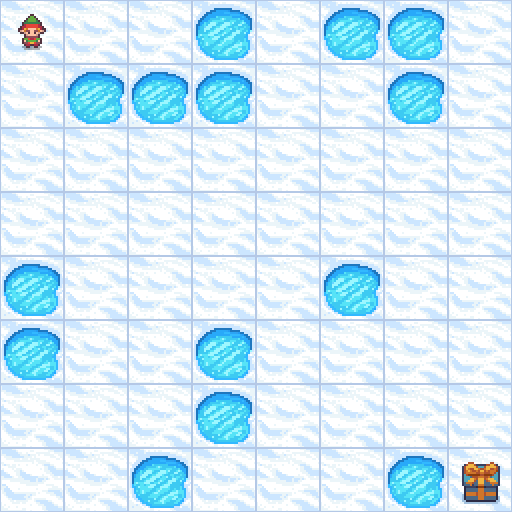

You took action noop.
You see:
- a hole 2 steps to your south-east.
- the goal 14 steps to your south-east.



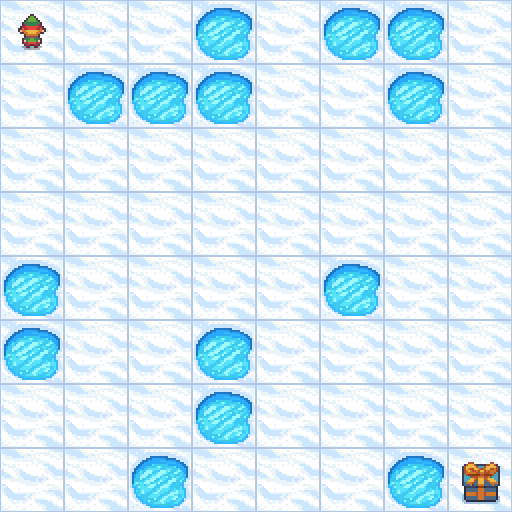

You took action move_up.
You see:
- a hole 2 steps to your south-east.
- the goal 14 steps to your south-east.



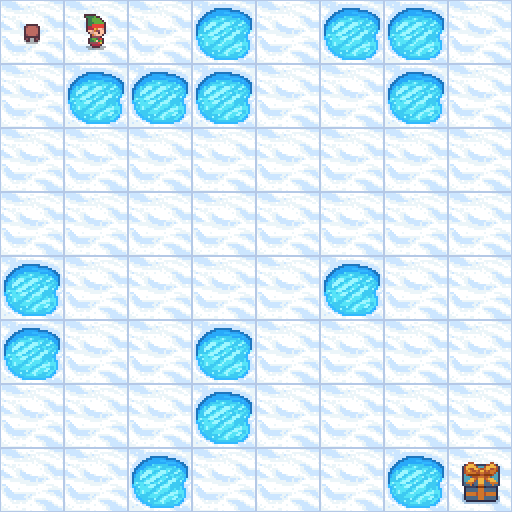

You took action move_right.
You see:
- a hole 2 steps to your east.
- a hole 1 steps to your south.
- a hole 2 steps to your south-east.
- the goal 13 steps to your south-east.



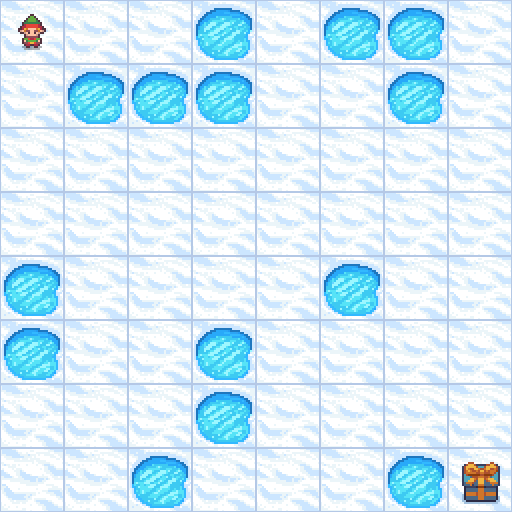

You took action noop.
You see:
- a hole 2 steps to your south-east.
- the goal 14 steps to your south-east.



In [29]:
observation, info = envs.reset(seed=42)
img = np.array(observation[0], dtype=np.uint8)
img = Image.fromarray(img)
display(img)
# print(f"step=0, {observation.shape=}, {info=}")
print(info['obs'][0])
for ix in range(3):
    action = envs.action_space.sample()
    observation, reward, terminated, truncated, info = envs.step(action)
    img = np.array(observation[0], dtype=np.uint8)
    img = Image.fromarray(img)
    display(img)
    print(f"step={ix+1}, {observation.shape=}, {reward=}, {terminated=}, {truncated=}, {info=}")
    #print(info['obs'][0])
envs.close()